# Pipeline for the anomaly detection on the SKAB using LSTM-based NN

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [ ]:
# libraries importing
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.Vanilla_LSTM import Vanilla_LSTM
from core.metrics import chp_score
from core.utils import load_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

### Method initialization

In [ ]:
# hyperparameters selection
N_STEPS = 5
EPOCHS = 25
BATCH_SIZE = 32
VAL_SPLIT = 0.2
PARAMS = [N_STEPS, EPOCHS, BATCH_SIZE, VAL_SPLIT]
Q = 0.99  # quantile for upper control limit (UCL) selection

In [ ]:
# model defining
model = Vanilla_LSTM(PARAMS)

In [ ]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(["anomaly", "changepoint"], axis=1)

    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)

    # model fitting
    model.fit(X, y)

    # results predicting
    residuals_train = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) * 5

    # results predicting
    X, y = split_sequences(
        StSc.transform(df.drop(["anomaly", "changepoint"], axis=1)), N_STEPS
    )
    lstm_residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    prediction = pd.Series(
        (lstm_residuals > UCL).astype(int).values, index=df[N_STEPS:].index
    ).fillna(0)

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

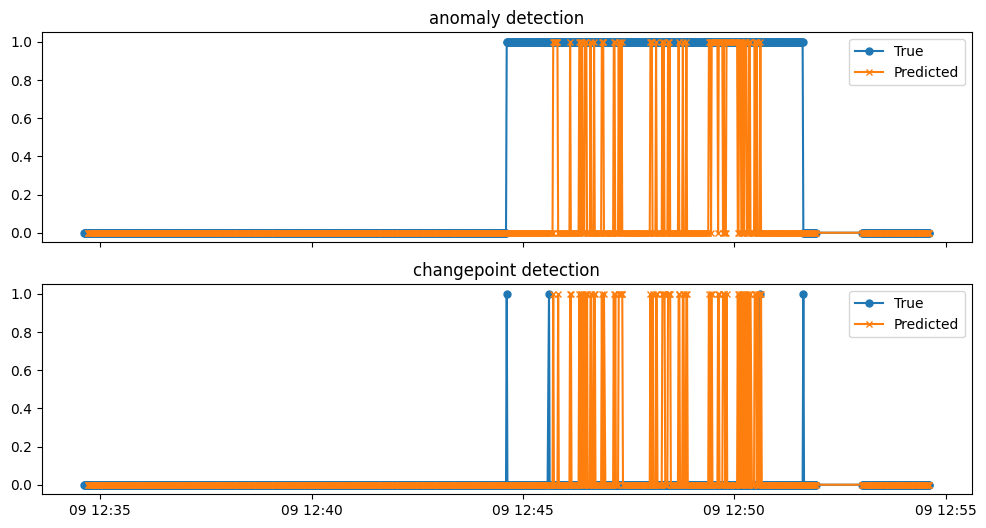

In [ ]:
# [donotremove]
true_outlier = [df.anomaly for df in list_of_df]
true_cp = [df.changepoint for df in list_of_df]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 5.64 %
Missing Alarm Rate 60.46 %
F1 metric 0.53


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 85
A number of FPs = 75
Average time 0 days 00:00:44.059090909


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  -2.05
LowFP  -  -21.46
LowFN  -  6.9
